In [1]:
import pandas as pd
import numpy as np
import urllib.request

import matplotlib.pyplot as plt

In [2]:
!pip install konlpy

In [4]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x2439fa03320>)

# 데이터 준비 & 전처리

In [22]:
df_train = pd.read_table('ratings_train.txt')
df_test = pd.read_table('ratings_test.txt')

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [24]:
# 1. 중복 데이터 제거
print(df_train['document'].nunique())
df_train = df_train.drop_duplicates(subset = ['document'])
print(df_train.nunique())

146182
id          146183
document    146182
label            2
dtype: int64


document가 다른 피쳐보다 1건 빠져있음 -> nan값이 존재함

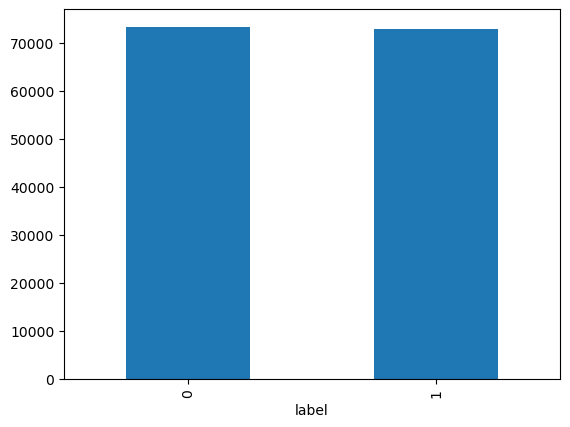

In [25]:
df_train['label'].value_counts().plot(kind = 'bar')
plt.show()

In [26]:
df_train = df_train.dropna(how = 'any')
df_train.isnull().values.sum() # 전체 데이터 프레임에서 NaN이 하나도 없음

0

In [27]:
import re

# 정규식을 활용해서 한글, 공백 한칸만 남기고 다 제거
df_train['document'] = df_train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣\s]", "", regex=True)
df_train.head()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\user\AppData\Local\Temp\ipykernel_21356\1742867539.py:4: SyntaxWarning: invalid escape sequence '\s'
  df_train['document'] = df_train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣\s]", "", regex=True)


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [28]:
# 테스트 데이터도 훈련 데이터와 동일하게 처리
df_test.drop_duplicates(subset=['document'], inplace=True)
df_test['document'] = df_test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True).str.strip()
df_test['document'].replace('', np.nan, inplace=True)
df_test = df_test.dropna(how='any')

C:\Users\user\AppData\Local\Temp\ipykernel_21356\3615180459.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['document'].replace('', np.nan, inplace=True)


In [29]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48852 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48852 non-null  int64 
 1   document  48852 non-null  object
 2   label     48852 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [30]:
from tqdm import tqdm_notebook
from konlpy.tag import Okt

okt = Okt()
X_train = []

for sentence in tqdm_notebook(df_train['document']):
    temp_X = okt.morphs(sentence, stem=True, norm=True)
    X_train.append(temp_X)

C:\Users\user\AppData\Local\Temp\ipykernel_21356\3807691332.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(df_train['document']):


  0%|          | 0/146182 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
import pickle

with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

print(X_train[:3])
print(y_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한', '다']]
[0 1 0]


# Text Vectorization
- 텍스트를 벡터화 시킬 수 있다는 이야기는 여러 알고리즘에 도입시킬 수 있다는 이야기

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_fVectorizer = TfidfVectorizer(
    # ngram_range = (1,2), # 유니그램 ~ 바이그램 까지 만들겠다.
    # min_df = 0.05,# 하위 빈도 5퍼센트 미만은 사용하지 않겠다. 
    # max_df = 0.95 # 상위 빈도 95퍼센트 이상은 사용하지 않겠다.정수로 입력하면 개수로 입력된다.
)

In [43]:
X_train = [' '.join(words) for words in X_train]
X_train[:3]

['아 더빙 진짜 짜증나다 목소리',
 '흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍다 않다',
 '너 무재 밓었 다그 래서 보다 추천 한 다']

In [44]:
X_train_tfidf = tfid_fVectorizer.fit_transform(X_train)
X_train_tfidf

<145791x41347 sparse matrix of type '<class 'numpy.float64'>'
	with 1214167 stored elements in Compressed Sparse Row format>

In [45]:
tfid_fVectorizer.vocabulary_

{'더빙': 8151,
 '진짜': 33005,
 '짜증나다': 33207,
 '목소리': 12708,
 '포스터': 37920,
 '보고': 15612,
 '초딩': 34307,
 '영화': 25084,
 '오버': 25384,
 '연기': 24758,
 '조차': 31701,
 '가볍다': 670,
 '않다': 22780,
 '무재': 13138,
 '밓었': 13930,
 '다그': 7241,
 '래서': 10185,
 '보다': 15643,
 '추천': 34692,
 '교도소': 3247,
 '이야기': 28383,
 '구먼': 3373,
 '솔직하다': 19704,
 '재미': 30175,
 '없다': 24104,
 '평점': 37816,
 '조정': 31676,
 '사이': 17783,
 '몬페': 12761,
 '익살스럽다': 28769,
 '돋보이다': 8723,
 '스파이더맨': 20692,
 '에서': 24269,
 '늙다': 7107,
 '보이다': 15756,
 '하다': 38685,
 '커스틴': 35377,
 '던스트': 8219,
 '너무나도': 6365,
 '이쁘다': 28233,
 '걸음': 1897,
 '떼다': 9738,
 '부터': 16347,
 '초등학교': 34304,
 '학년': 38889,
 '생인': 18460,
 '살다': 17995,
 'ㅋㅋㅋ': 279,
 '반개': 14335,
 '아깝다': 22056,
 '원작': 26775,
 '긴장감': 4535,
 '제대로': 31313,
 '살리다': 18008,
 '나오다': 5687,
 '이응경': 28488,
 '길용우': 4559,
 '생활': 18482,
 '인지': 28941,
 '정말': 31022,
 '해도': 39315,
 '그것': 3864,
 '보단': 15648,
 '낫다': 6167,
 '납치': 6165,
 '감금': 1019,
 '반복': 14379,
 '드라마': 9165,
 '가족': 799,
 '사람': 17632,
 '액션': 231

# 분류 모델 만들기
- LogisticRegression

In [47]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=100000).fit(X_train_tfidf, y_train)
log_reg

LogisticRegression(max_iter=100000)

In [48]:
with open("X_test.pkl", "rb") as f :
    X_test = pickle.load(f)

X_test[:3]

['굳다 ㅋ', '뭐 야 이 평점 들 은 나쁘다 않다 점 짜다 리 는 더 더욱 아니다', '지루하다 않다 완전 막장 임 돈 주다 보기 에는']

In [49]:
with open("y_test.pkl", "rb") as f :
    y_test = pickle.load(f)

y_test

0        1
2        0
3        0
4        0
5        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: label, Length: 48995, dtype: int64

In [50]:
# 훈련 데이터로 만들어진 tfid_vectorizer를 테스트 데이터 세트에 적용
X_test_vector = tfid_fVectorizer.transform(X_test)

In [51]:
from sklearn.metrics import accuracy_score

accuracy_score(log_reg.predict(X_test_vector), y_test)

0.831166445555669

In [52]:
# 이 모델을 배포한다면..?
#  user가 어떻게 문장을 입력할까....?
#  user가 데이터를 입력 할 때 ["영화 너무 재밌어요."] 이렇게 입력하지 않음.
#  user는 데이터를 입력 할 때 문장만 입력한다. "영화 너무 재미있어요"

def sentiment_predict(sentence):
  sentence_norm_stem = okt.morphs(sentence, stem=True, norm=True)
  sentence_test = ' '.join(sentence_norm_stem)

  text_vector = tfid_fVectorizer.transform([sentence_test])

  pred = log_reg.predict(text_vector)
  print(sentence, "====>", pred)


In [53]:
sentiment_predict("너무 재미있는 영화!")

너무 재미있는 영화! ====> [1]


In [54]:
sentiment_predict("영화를 보다가 너무 졸려서 뒷 사람이 발로 차는것도 몰랐어요")

영화를 보다가 너무 졸려서 뒷 사람이 발로 차는것도 몰랐어요 ====> [0]


In [55]:
sentiment_predict("영화를 보다가 너무 졸려서 뒷 사람이 발로 차는것도 몰랐어요")

영화를 보다가 너무 졸려서 뒷 사람이 발로 차는것도 몰랐어요 ====> [0]
